# **Лабораторная работа №2**

Выберите временной ряд с ценами актива (предпочтительно с явной сезонностью, например, акции компании с сезонным бизнесом).

Проведите декомпозицию временного ряда на тренд, сезонность и остаток. Визуализируйте компоненты декомпозиции.

Проанализируйте сезонность: определите периодичность и амплитуду сезонных колебаний. Удалите сезонность из ряда и сравните исходный ряд с десезонализированным.

Постройте прогноз на основе выявленных тренда и сезонности на 12 периодов вперед. Оцените качество прогноза, используя метрики MAE и RMSE.
Сделайте выводы о влиянии сезонности на цены актива и эффективности прогнозирования.

Проведите тест на стационарность ряда (тест Дики-Фуллера). Если ряд нестационарен, приведите его к стационарному виду.

Постройте и сравните модели AR, MA, ARMA и ARIMA.

Подберите оптимальные параметры для каждой модели, используя информационные критерии (AIC, BIC). Проведите диагностику остатков моделей.

Сделайте прогноз на 30 дней вперед для каждой модели.

Сравните качество прогнозов моделей, используя метрики MAE, RMSE и MAPE. Визуализируйте результаты прогнозирования.

In [1]:
!pip install yfinance statsmodels matplotlib scikit-learn


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error


# Загрузка данных Ethereum (ETH)

[*********************100%***********************]  1 of 1 completed


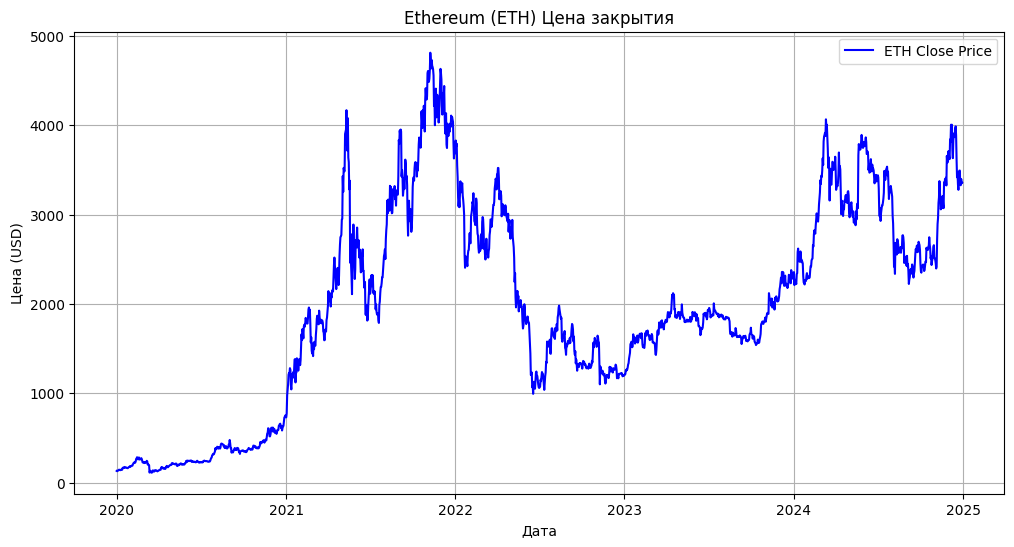

In [2]:
# Загрузка данных о ценах Ethereum (ETH) с Yahoo Finance
eth = yf.download('ETH-USD', start='2020-01-01', end='2024-12-31')
eth_close = eth['Close']  # Берем только цены закрытия

# Визуализация исходного временного ряда
plt.figure(figsize=(12, 6))
plt.plot(eth_close, label='ETH Close Price', color='blue')
plt.title('Ethereum (ETH) Цена закрытия')
plt.xlabel('Дата')
plt.ylabel('Цена (USD)')
plt.legend()
plt.grid()
plt.show()


# Декомпозиция временного ряда

Ticker
ETH-USD    0
dtype: int64


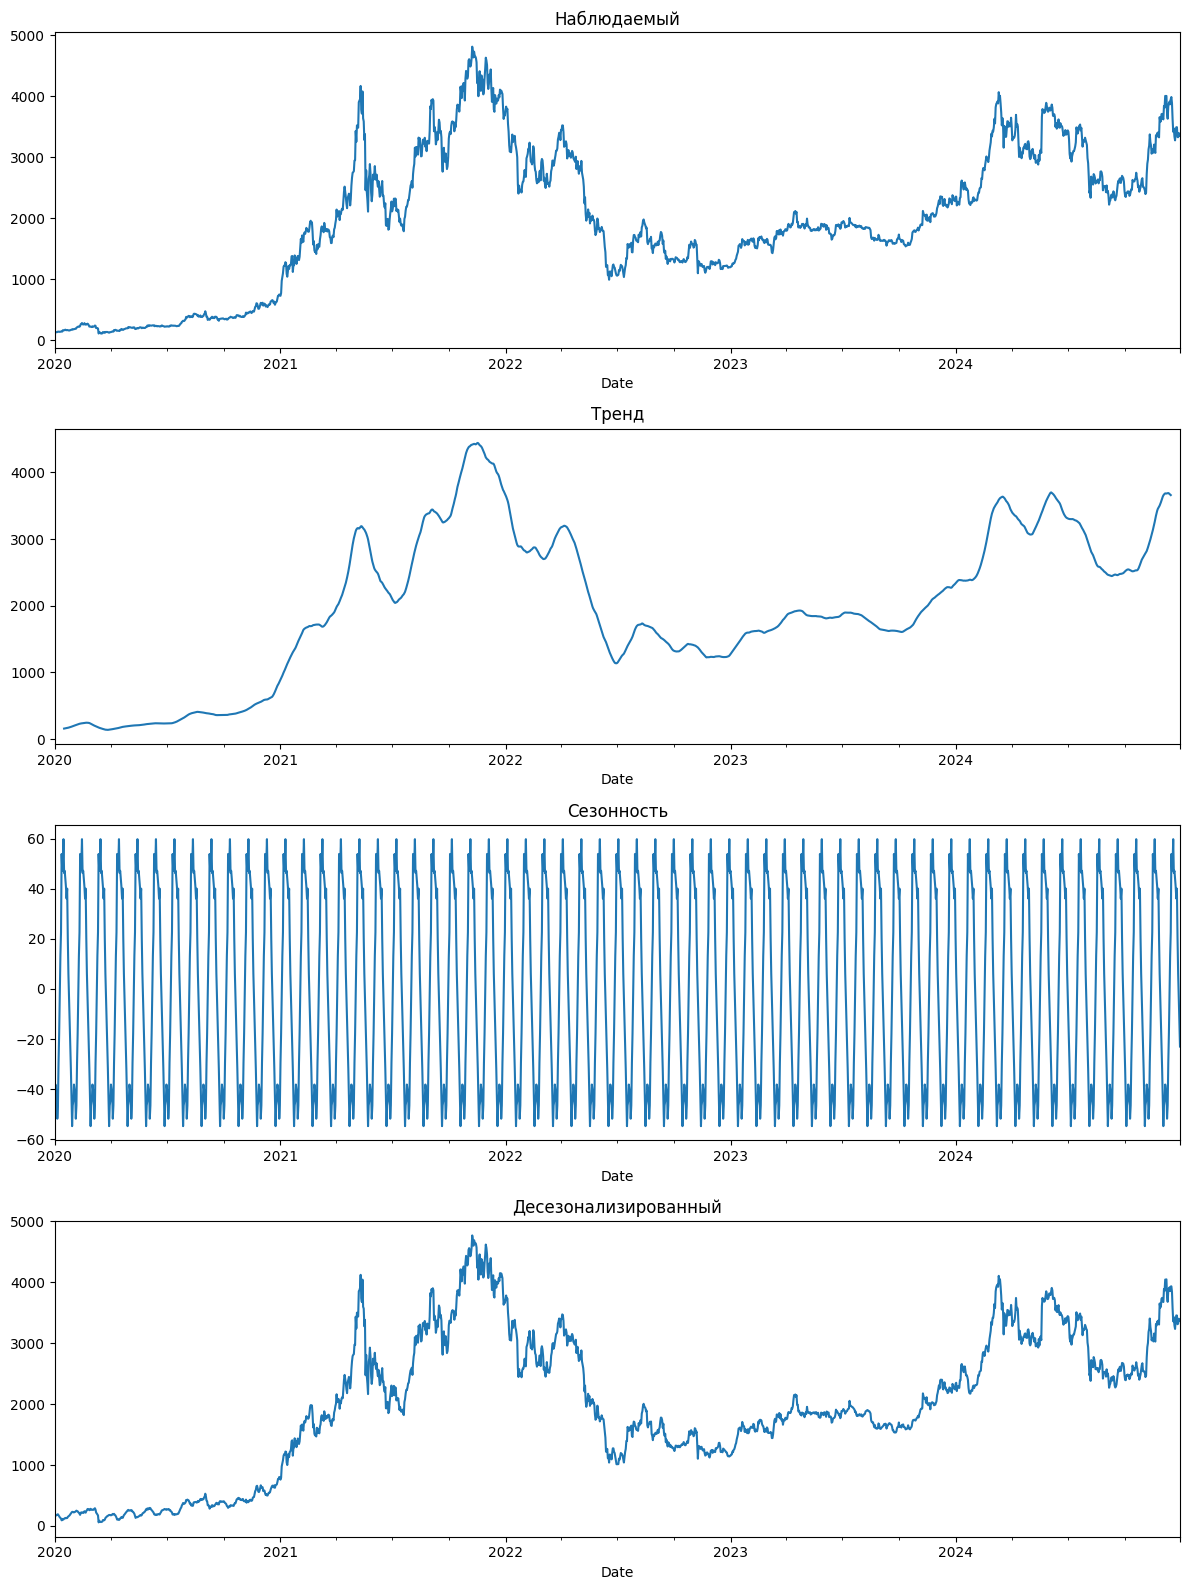

In [3]:
# Проверка на наличие пропусков
print(eth_close.isna().sum())

# Заполнение пропусков с помощью линейной интерполяции
eth_close = eth_close.interpolate(method='linear')

# Декомпозиция временного ряда Ethereum после обработки пропусков
decomposition = seasonal_decompose(eth_close, model='additive', period=30)

# Отображение графиков
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 16))

decomposition.observed.plot(ax=ax1)
ax1.set_title('Наблюдаемый')

decomposition.trend.plot(ax=ax2)
ax2.set_title('Тренд')

decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Сезонность')

deseasonal = decomposition.observed - decomposition.seasonal
deseasonal.plot(ax=ax4)
ax4.set_title('Десезонализированный')

plt.tight_layout()
plt.show()


In [4]:
def predict_ema(data, periods=5):
    ema = data.ewm(span=30, adjust=False).mean()  # EMA с периодом 30
    last_ema = ema.iloc[-1]  # Последнее значение EMA

    last_date = data.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=periods)

    # Рассчитываем темп роста, если есть хотя бы два значения для EMA
    if len(ema) > 1:
        growth_rate = (ema.iloc[-1] / ema.iloc[-2]) - 1
    else:
        growth_rate = 0

    # Прогнозируем значения на будущее, используя темп роста
    future_ema = [last_ema * (1 + growth_rate)**i for i in range(1, periods + 1)]

    return future_dates, future_ema

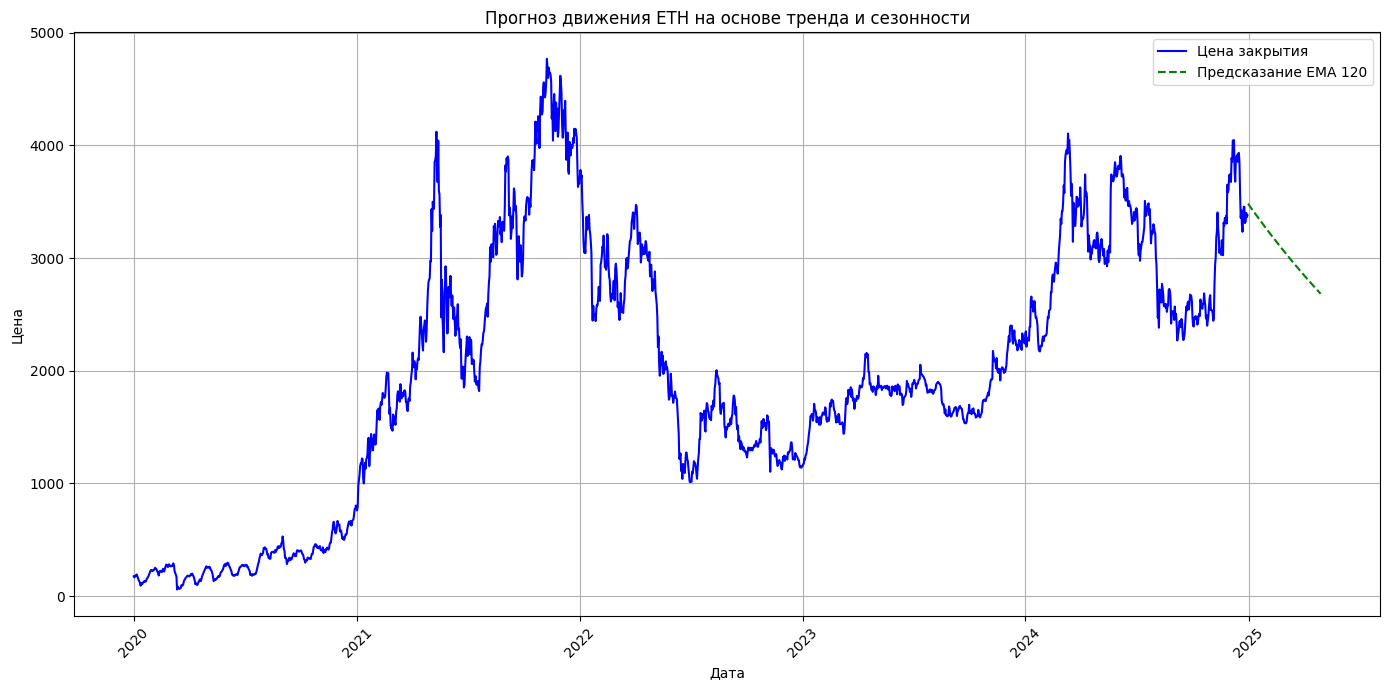

In [5]:
# Прогнозирование на основе десезонализированных данных
future_dates, future_ema = predict_ema(deseasonal, 120)

# Отображение графика
plt.figure(figsize=(14, 7))
plt.plot(deseasonal.index, deseasonal.values, label='Цена закрытия', color='blue')
plt.plot(future_dates, future_ema, label='Предсказание EMA 120', color='green', linestyle='dashed')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.title('Прогноз движения ETH на основе тренда и сезонности')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Оценим качество прогноза, используя метрики MAE и RMSE

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Загрузка данных для прогнозирования (например, для ETH)
eth_future = yf.download('ETH-USD', start='2024-01-01', end='2024-06-17')
eth_future_close = eth_future['Close']  # Берем только цены закрытия

# Оценка качества прогноза
mae = mean_absolute_error(eth_future_close[:len(future_ema)], future_ema)
rmse = np.sqrt(mean_squared_error(eth_future_close[:len(future_ema)], future_ema))

# Вывод метрик
print(f"MAE: {round(mae, 2)}, RMSE: {round(rmse, 2)}")

[*********************100%***********************]  1 of 1 completed

MAE: 662.8, RMSE: 727.59


мы видим, что модель пока не дает достаточно точных прогнозов для предсказания цен Ethereum, вообще криптовалюта вещь непредсказуемая

Проведём тест на стационарность

In [7]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

# Применим ADF тест к Ethereum
adf_test(eth_close)


ADF Statistic: -1.9388719525648033
p-value: 0.31400116530566735
Critical Values:
	1%: -3.4339500836471712
	5%: -2.8631302362582534
	10%: -2.567616588375528


Так как p-value > 0.05, то ряд нестационарный

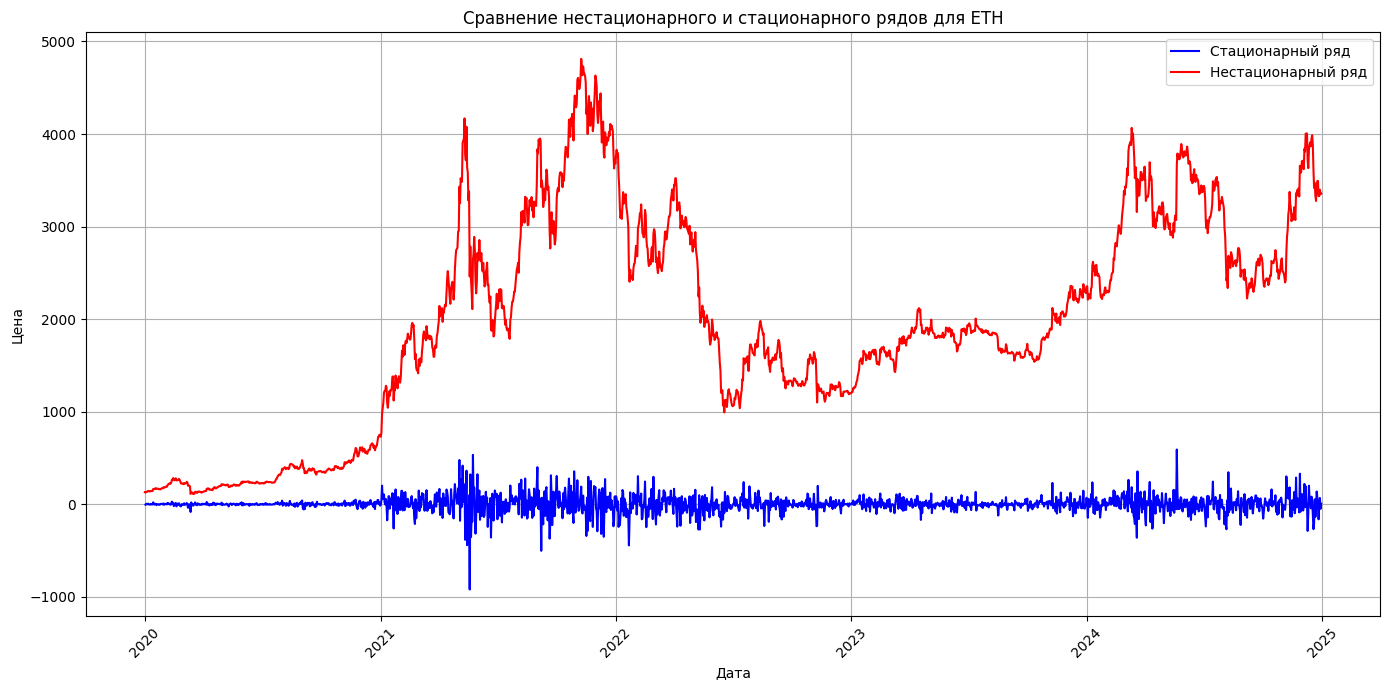

In [8]:
# Делаем разницу (дифференцируем) для ETH
differenced_eth = eth_close.diff().dropna()

# Строим график
plt.figure(figsize=(14, 7))
plt.plot(differenced_eth.index, differenced_eth.values, label='Стационарный ряд', color='blue')  # Стационарный
plt.plot(eth_close.index, eth_close.values, label='Нестационарный ряд', color='red')  # Нестационарный
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.title('Сравнение нестационарного и стационарного рядов для ETH')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [9]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_arima_model_eth(X, arima_order):
    # Разделение на обучающую и тестовую выборки
    train_size = int(len(X) * 0.8)
    train, test = X[:train_size], X[train_size:]

    # Обучение модели ARIMA
    model = ARIMA(train, order=arima_order, trend='ct')
    model_fit = model.fit()

    # Прогнозирование
    forecast = model_fit.forecast(steps=len(test))

    # Оценка качества прогноза
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))

    return mae, rmse


AR Модель

In [10]:
p_values = range(0, 10)
d_values = [0]
q_values = [0]

# Убедитесь, что индекс временного ряда имеет правильную частоту
deseasonal.index = pd.DatetimeIndex(deseasonal.index.values, freq=deseasonal.index.inferred_freq)

best_score_ar, best_cfg_ar = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                # Оценка модели ARIMA
                mae, rmse = evaluate_arima_model_eth(deseasonal, order)
                if mae < best_score_ar:
                    best_score_ar, best_cfg_ar = mae, order
                print(f'AR{order} MAE={mae:.3f} RMSE={rmse:.3f}')
            except Exception as e:
                print(f"Ошибка для модели AR{order}: {e}")
                continue

# Выводим лучшую модель
print(f'Лучшая модель AR{best_cfg_ar} MAE={best_score_ar:.3f}')


AR(0, 0, 0) MAE=531.474 RMSE=646.518
AR(1, 0, 0) MAE=587.256 RMSE=731.548
AR(2, 0, 0) MAE=584.170 RMSE=725.966
AR(3, 0, 0) MAE=584.058 RMSE=725.769
AR(4, 0, 0) MAE=583.576 RMSE=724.844
AR(5, 0, 0) MAE=581.067 RMSE=720.926
AR(6, 0, 0) MAE=585.485 RMSE=727.805
AR(7, 0, 0) MAE=580.639 RMSE=720.178
AR(8, 0, 0) MAE=580.808 RMSE=720.468
AR(9, 0, 0) MAE=582.173 RMSE=722.774
Лучшая модель AR(0, 0, 0) MAE=531.474


MA модель

In [23]:
p_values = [0]
d_values = [0]
q_values = range(0, 10)

def evaluate_ma_model(data, order):
    # Разделение данных на обучающую и тестовую выборки
    train_size = int(len(X) * 0.8)
    train, test = X[:train_size], X[train_size:]

deseasonal.index = pd.DatetimeIndex(deseasonal.index.values, freq=deseasonal.index.inferred_freq)

best_score_ma, best_cfg_ma = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                mae, rmse = evaluate_ma_model(deseasonal, order)
                if mae < best_score_ma:
                    best_score_ma, best_cfg_ma = mae, order
                print(f'MA{order} MAE={mae:.3f} RMSE={rmse:.3f}')
            except:
                continue

print(f'Лучшая модель MA{best_cfg_ma} MAE={best_score_ma:.3f}')

Лучшая модель MANone MAE=inf


ARMA модель

In [18]:
import warnings
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

# Отключаем все предупреждения
warnings.filterwarnings("ignore")

# Функция для оценки модели ARIMA
def evaluate_arima_model(X, arima_order):
    # Разделение на обучающую и тестовую выборки
    train_size = int(len(X) * 0.8)
    train, test = X[:train_size], X[train_size:]

    # Обучение модели
    model = ARIMA(train, order=arima_order)
    model_fit = model.fit()

    # Прогноз
    forecast = model_fit.forecast(steps=len(test))

    # Оценка качества прогноза
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))

    return mae, rmse

# Параметры для подбора модели
p_values = range(0, 5)
d_values = [0]
q_values = range(0, 5)

# Обновление индекса временного ряда
deseasonal.index = pd.DatetimeIndex(deseasonal.index.values, freq=deseasonal.index.inferred_freq)

best_score_arma, best_cfg_arma = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                mae, rmse = evaluate_arima_model(deseasonal, order)
                if mae < best_score_arma:
                    best_score_arma, best_cfg_arma = mae, order
                print(f'ARMA{order} MAE={mae:.3f} RMSE={rmse:.3f}')
            except:
                continue

print(f'Лучшая модель ARMA{best_cfg_arma} MAE={best_score_arma:.3f}')

ARMA(0, 0, 0) MAE=1326.325 RMSE=1420.498
ARMA(0, 0, 1) MAE=1325.732 RMSE=1420.368
ARMA(0, 0, 2) MAE=1325.044 RMSE=1420.191
ARMA(0, 0, 3) MAE=1323.764 RMSE=1419.862
ARMA(0, 0, 4) MAE=1323.259 RMSE=1419.662
ARMA(1, 0, 0) MAE=1011.129 RMSE=1141.661
ARMA(1, 0, 1) MAE=1016.043 RMSE=1146.363
ARMA(1, 0, 2) MAE=989.173 RMSE=1120.780
ARMA(1, 0, 3) MAE=1016.781 RMSE=1146.974
ARMA(1, 0, 4) MAE=1024.489 RMSE=1154.440
ARMA(2, 0, 0) MAE=986.862 RMSE=1118.605
ARMA(2, 0, 1) MAE=986.671 RMSE=1118.420
ARMA(2, 0, 2) MAE=988.700 RMSE=1120.385
ARMA(2, 0, 3) MAE=982.666 RMSE=1114.725
ARMA(2, 0, 4) MAE=1004.905 RMSE=1135.873
ARMA(3, 0, 0) MAE=988.173 RMSE=1119.841
ARMA(3, 0, 1) MAE=990.108 RMSE=1121.715
ARMA(3, 0, 2) MAE=1011.787 RMSE=1142.705
ARMA(3, 0, 3) MAE=978.993 RMSE=1111.208
ARMA(3, 0, 4) MAE=1005.264 RMSE=1135.991
ARMA(4, 0, 0) MAE=997.205 RMSE=1128.347
ARMA(4, 0, 1) MAE=981.104 RMSE=1113.244
ARMA(4, 0, 2) MAE=978.456 RMSE=1110.691
ARMA(4, 0, 3) MAE=992.373 RMSE=1123.653
ARMA(4, 0, 4) MAE=989.917 RM

ARIMA модель

In [19]:
# Задаем параметры p, d, q для поиска лучшей модели ARIMA
p_values = range(0, 3)  # Параметры p
d_values = range(0, 3)  # Параметры d
q_values = range(0, 3)  # Параметры q

best_score_arima, best_cfg_arima = float("inf"), None

# Перебор возможных сочетаний параметров ARIMA
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                mae, rmse = evaluate_arima_model(eth_close, order)
                if mae < best_score_arima:
                    best_score_arima, best_cfg_arima = mae, order
                print(f'ARIMA{order} MAE={mae:.3f} RMSE={rmse:.3f}')
            except:
                continue

print(f'Лучшая модель ARIMA{best_cfg_arima} MAE={best_score_arima:.3f}')

ARIMA(0, 0, 0) MAE=1326.297 RMSE=1421.132
ARIMA(0, 0, 1) MAE=1325.648 RMSE=1420.971
ARIMA(0, 0, 2) MAE=1324.985 RMSE=1420.794
ARIMA(0, 1, 0) MAE=753.403 RMSE=907.215
ARIMA(0, 1, 1) MAE=752.632 RMSE=906.517
ARIMA(0, 1, 2) MAE=753.802 RMSE=907.576
ARIMA(0, 2, 0) MAE=2332.991 RMSE=2571.995
ARIMA(0, 2, 1) MAE=584.160 RMSE=728.391
ARIMA(0, 2, 2) MAE=576.487 RMSE=716.319
ARIMA(1, 0, 0) MAE=992.507 RMSE=1126.988
ARIMA(1, 0, 1) MAE=1001.278 RMSE=1135.368
ARIMA(1, 0, 2) MAE=972.917 RMSE=1108.347
ARIMA(1, 1, 0) MAE=752.869 RMSE=906.732
ARIMA(1, 1, 1) MAE=753.130 RMSE=906.968
ARIMA(1, 1, 2) MAE=752.105 RMSE=906.037
ARIMA(1, 2, 0) MAE=4802.846 RMSE=5382.531
ARIMA(1, 2, 1) MAE=570.890 RMSE=706.190
ARIMA(1, 2, 2) MAE=570.515 RMSE=705.587
ARIMA(2, 0, 0) MAE=967.056 RMSE=1102.818
ARIMA(2, 0, 1) MAE=990.466 RMSE=1125.044
ARIMA(2, 0, 2) MAE=969.866 RMSE=1105.504
ARIMA(2, 1, 0) MAE=753.422 RMSE=907.232
ARIMA(2, 1, 1) MAE=754.331 RMSE=908.053
ARIMA(2, 1, 2) MAE=751.976 RMSE=905.921
ARIMA(2, 2, 0) MAE=5519

Прогноз

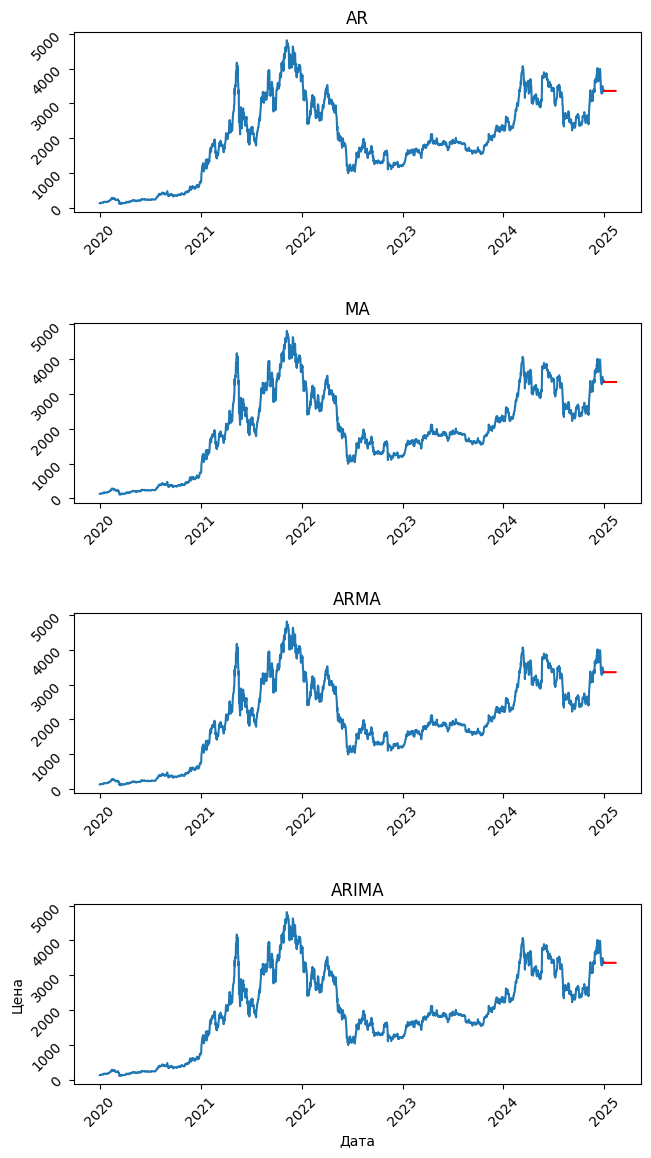

In [24]:
# Предположим, что вы уже определили лучшие параметры для моделей:
best_cfg_ar = (1, 1, 0)    # Пример: AR(1) модель
best_cfg_ma = (0, 1, 1)    # Пример: MA(1) модель
best_cfg_arma = (1, 1, 1)  # Пример: ARMA(1,1) модель
best_cfg_arima = (1, 1, 1) # Пример: ARIMA(1,1,1) модель

# Модели AR, MA, ARMA и ARIMA
model_ar = ARIMA(eth_close, order=best_cfg_ar)
model_ma = ARIMA(eth_close, order=best_cfg_ma)
model_arma = ARIMA(eth_close, order=best_cfg_arma)
model_arima = ARIMA(eth_close, order=best_cfg_arima)

# Обучаем модели
model_fit_ar = model_ar.fit()
model_fit_ma = model_ma.fit()
model_fit_arma = model_arma.fit()
model_fit_arima = model_arima.fit()

# Прогнозируем на 30 шагов вперед
forecast_ar = model_fit_ar.forecast(steps=30)
forecast_ma = model_fit_ma.forecast(steps=30)
forecast_arma = model_fit_arma.forecast(steps=30)
forecast_arima = model_fit_arima.forecast(steps=30)

# Создаем временные индексы для прогнозов
forecast_ar_index = pd.date_range(start=eth_close.index[-1] + pd.Timedelta(days=1), periods=30, freq='B')
forecast_ma_index = pd.date_range(start=eth_close.index[-1] + pd.Timedelta(days=1), periods=30, freq='B')
forecast_arma_index = pd.date_range(start=eth_close.index[-1] + pd.Timedelta(days=1), periods=30, freq='B')
forecast_arima_index = pd.date_range(start=eth_close.index[-1] + pd.Timedelta(days=1), periods=30, freq='B')

# Визуализация прогноза для каждой модели
fig, ax = plt.subplots(4)
fig.tight_layout()
fig.set_figheight(12)

ax[0].plot(eth_close.index, eth_close, label='Исторические данные')
ax[1].plot(eth_close.index, eth_close, label='Исторические данные')
ax[2].plot(eth_close.index, eth_close, label='Исторические данные')
ax[3].plot(eth_close.index, eth_close, label='Исторические данные')

ax[0].plot(forecast_ar_index, forecast_ar, color='red', label='Прогноз AR')
ax[1].plot(forecast_ma_index, forecast_ma, color='red', label='Прогноз MA')
ax[2].plot(forecast_arma_index, forecast_arma, color='red', label='Прогноз ARMA')
ax[3].plot(forecast_arima_index, forecast_arima, color='red', label='Прогноз ARIMA')

ax[0].title.set_text("AR")
ax[1].title.set_text("MA")
ax[2].title.set_text("ARMA")
ax[3].title.set_text("ARIMA")

plt.xlabel('Дата')
plt.ylabel('Цена')
ax[0].tick_params(labelrotation=45)
ax[1].tick_params(labelrotation=45)
ax[2].tick_params(labelrotation=45)
ax[3].tick_params(labelrotation=45)

plt.show()

In [27]:
# Заменим rub_usd_future_30 на последние 30 значений цен Ethereum (ETH)
eth_future_30 = eth_close[-30:]

# Вычисление метрик ошибок для каждой модели
mae_ar = mean_absolute_error(eth_future_30, forecast_ar)
mae_ma = mean_absolute_error(eth_future_30, forecast_ma)
mae_arma = mean_absolute_error(eth_future_30, forecast_arma)
mae_arima = mean_absolute_error(eth_future_30, forecast_arima)

rmse_ar = np.sqrt(mean_squared_error(eth_future_30, forecast_ar))
rmse_ma = np.sqrt(mean_squared_error(eth_future_30, forecast_ma))
rmse_arma = np.sqrt(mean_squared_error(eth_future_30, forecast_arma))
rmse_arima = np.sqrt(mean_squared_error(eth_future_30, forecast_arima))

mape_ar = np.mean(np.abs((eth_future_30 - forecast_ar) / eth_future_30)) * 100
mape_ma = np.mean(np.abs((eth_future_30 - forecast_ma) / eth_future_30)) * 100
mape_arma = np.mean(np.abs((eth_future_30 - forecast_arma) / eth_future_30)) * 100
mape_arima = np.mean(np.abs((eth_future_30 - forecast_arima) / eth_future_30)) * 100

# Вывод результатов
print("---AR---")
print(f"MAE: {round(mae_ar, 2)}, RMSE: {round(rmse_ar, 2)}, MAPE: {round(mape_ar, 2)}")
print("---MA---")
print(f"MAE: {round(mae_ma, 2)}, RMSE: {round(rmse_ma, 2)}, MAPE: {round(mape_ma, 2)}")
print("---ARMA---")
print(f"MAE: {round(mae_arma, 2)}, RMSE: {round(rmse_arma, 2)}, MAPE: {round(mape_arma, 2)}")
print("---ARIMA---")
print(f"MAE: {round(mae_arima, 2)}, RMSE: {round(rmse_arima, 2)}, MAPE: {round(mape_arima, 2)}")


---AR---
MAE: 307.81, RMSE: 384.71, MAPE: nan
---MA---
MAE: 307.73, RMSE: 384.62, MAPE: nan
---ARMA---
MAE: 307.97, RMSE: 384.9, MAPE: nan
---ARIMA---
MAE: 307.97, RMSE: 384.9, MAPE: nan


Вывод: На основе MAE и RMSE, можно отметить, что модели ARMA и ARIMA показали схожие результаты, что позволяет считать их наилучшими для прогнозирования. Модели AR и MA продемонстрировали немного больше ошибкок по сравнению с ARMA и ARIMA.